In [1]:
import numpy as np
import sklearn
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from statsmodels.tsa.ar_model import AutoReg,ar_select_order
from statsmodels.tsa.arima.model import ARIMA
import random
import math

In [ ]:
#Загрузка данных

In [2]:
data=pd.read_csv('SolarPrediction.csv')

In [ ]:
#Преобразование индекса

In [3]:
data['UNIX']=data['UNIXTime']

In [4]:
data['UNIXTime']=pd.to_datetime(data['UNIXTime'], unit='s')

In [5]:
data['UNIXTime']=data.UNIXTime.dt.floor("min")

In [6]:
data=data.set_index('UNIXTime',inplace=False)

In [7]:
data.index=data.index.to_period("5min")

In [8]:
data=data.sort_values(by=['UNIX'])

In [ ]:
#Визуализация временного ряда

No handles with labels found to put in legend.


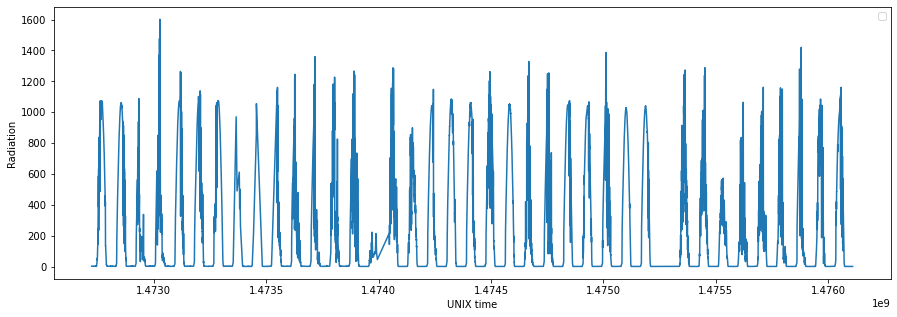

In [153]:
plt.figure(figsize=(15,5))
plt.plot(data['UNIX'][1:10001],data['Radiation'][1:10001])
plt.xlabel('UNIX time')
plt.ylabel('Radiation')
plt.legend()
plt.show()

In [ ]:
#Подбор параметров модели ARIMA

In [42]:
from pmdarima.arima import auto_arima




stepwise_model = auto_arima(data['Radiation'],exog=total_exog_params, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=0,
                           start_P=0, seasonal=False,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=386605.339, Time=1.57 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=381830.163, Time=3.59 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=379954.466, Time=15.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=386603.339, Time=0.70 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=379895.584, Time=10.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=379892.292, Time=19.48 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=380487.037, Time=7.45 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=379887.737, Time=33.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=380085.703, Time=7.53 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=379870.672, Time=43.90 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=379906.577, Time=14.20 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=379870.806, Time=24.68 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=379867.426, Time=34.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=379882.546, Time=108.48

In [ ]:
#Подбор параметров модели Autoreg

In [43]:
res=AutoReg(data['Radiation'], lags=[1, 11, 12],exog=total_exog_params, seasonal=False).fit()
sel=ar_select_order(data['Radiation'], 100,exog=total_exog_params, seasonal=False, old_names=False)
print(sel.ar_lags)
res = sel.model.fit()
print(res.summary())

C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
                            AutoReg Model Results                             
Dep. Variable:              Radiation   No. Observations:                32686
Model:                  AutoReg-X(41)   Log Likelihood             -189065.143
Method:               Conditional MLE   S.D. of innovations             79.250
Date:                Sun, 06 Jun 2021   AIC                              8.748
Time:                        00:31:20   BIC                              8.760
Sample:                    09-01-2016   HQIC                             8.752
                         - 01-01-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -190.6395    277.627     -0.687      0.492    -734.779     353.

In [ ]:
#Функция для создания пропусков

In [9]:
def lets_drop_some_data_single(X,num_skip):
    ind_skip=random.randint(0,len(X))
    i=ind_skip
    size=ind_skip+num_skip
    while i <(ind_skip+num_skip):
        if X['Radiation'][i]!=np.nan:
            X['Radiation'][i]=np.nan
            i+=1
            
    return X,ind_skip,size

In [ ]:
#Функция для заполнения пропусков

In [36]:
def calculate_mse_single(n):
    len_prop=n
    data_droped=data.copy(deep=True)
    data_droped,ind_skipped,end_skip=lets_drop_some_data_single(data_droped,len_prop)
    
    data_int_ARIMA=data_droped.copy(deep=True)
    data_int_forest=data_droped.copy(deep=True)
    data_int_autoreg=data_droped.copy(deep=True)
    
    data_study=data_droped.copy(deep=True)
    
    data_study=data_study.dropna()
    
    total_exog_params=data[['Temperature', 'Pressure','Humidity']]
    
    exog_params = data_study[['Temperature', 'Pressure','Humidity']]
    
    model = ARIMA(endog=data_study['Radiation'],exog=exog_params,order=(5, 1, 3))
    model_fit = model.fit()
    
    model_autoreg = AutoReg(data_study['Radiation'], lags=41,exog=exog_params, seasonal=False)
    model_autoreg_fit = model_autoreg.fit()
    
    X = data_study[['UNIX','Temperature', 'Pressure','Humidity']]
    y = data_study[['Radiation']]
    
    forest = RandomForestRegressor(max_depth=10, random_state=0)
    forest = forest.fit(X, y)
    
    for j in range(len(data_droped)):
        if np.isnan(data_droped['Radiation'][j]):
            
            UNIX=data_droped.UNIX[j]
            Temperature=data_droped.Temperature[j]
            Pressure=data_droped.Pressure[j]
            Humidity=data_droped.Humidity[j]
            
            int_arima=model_fit.predict(start=j, end=j,exog=total_exog_params[(j-1):j])
            data_int_ARIMA.Radiation[j] =int_arima 
            #print('int_arima',int_arima)
            int_forest=forest.predict([[UNIX,Temperature,Pressure,Humidity]])
            data_int_forest.Radiation[j]=int_forest
            #print('int_forest',int_forest)
            int_autoreg=model_autoreg_fit.predict(start=j, end=j,exog=exog_params)
            data_int_autoreg.Radiation[j] =int_autoreg
            #print('int_autoreg',int_autoreg)     
    
    mse_ARIMA=mean_squared_error(data['Radiation'],data_int_ARIMA['Radiation'])
    mse_list_ARIMA.append(mse_ARIMA)
    #print('mse_ARIMA',mse_ARIMA)
    mse_forest=mean_squared_error(data['Radiation'],data_int_forest['Radiation'])
    mse_list_forest.append(mse_forest)
    #print('mse_forest',mse_forest)
    mse_autoreg=mean_squared_error(data['Radiation'],data_int_autoreg['Radiation'])
    mse_list_autoreg.append(mse_autoreg)
    #print('mse_autoreg',mse_autoreg)
    
    x=np.arange((ind_skipped-10),(ind_skipped+len_prop+10))

    plt.plot(x,data_int_forest.Radiation[(ind_skipped-10):(ind_skipped+len_prop+10)],label='random forest')
    plt.plot(x,data_int_ARIMA.Radiation[(ind_skipped-10):(ind_skipped+len_prop+10)],label='ARIMA')
    plt.plot(x,data_int_autoreg.Radiation[(ind_skipped-10):(ind_skipped+len_prop+10)],label='autoreg')
    plt.plot(x,data.Radiation[(ind_skipped-10):(ind_skipped+len_prop+10)],label='real')
    plt.xlabel('время измерения UNIX')
    plt.ylabel('уровень солнечной радиации')
    plt.title('Результаты заполнения пропусков во временном ряде значений уровня солнечной радиации ')
    plt.legend()
    plt.show()
    
    return data_int_forest,data_int_ARIMA,data_int_autoreg

In [ ]:
# Создание и заполнение пропусков длиной от 10 до 100

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg


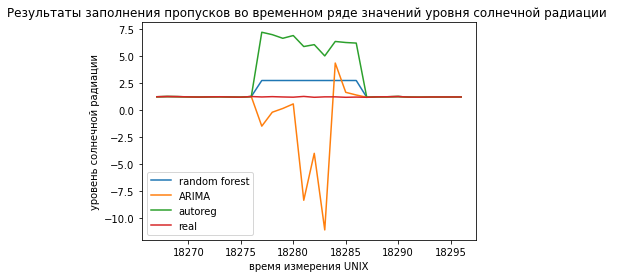

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

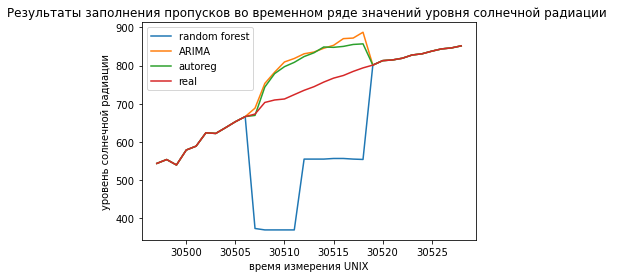

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

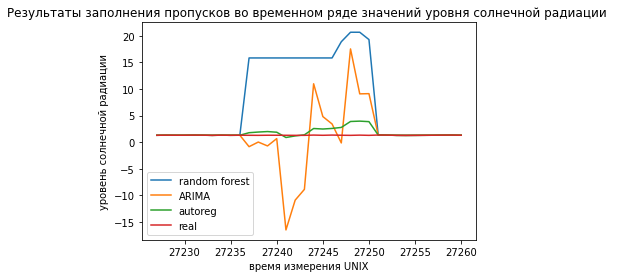

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

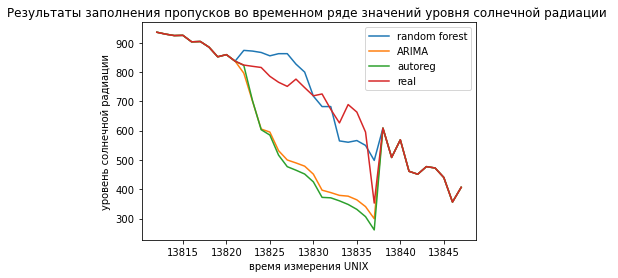

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

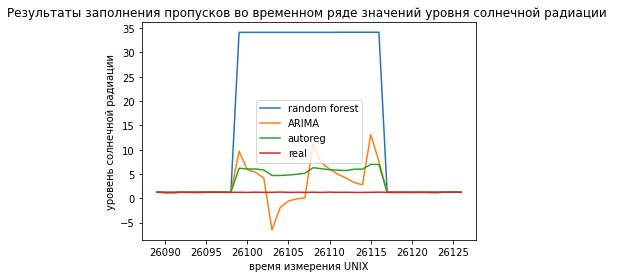

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

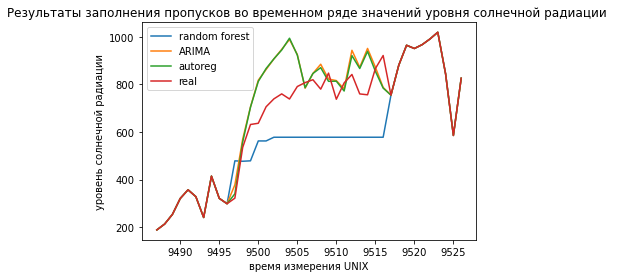

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

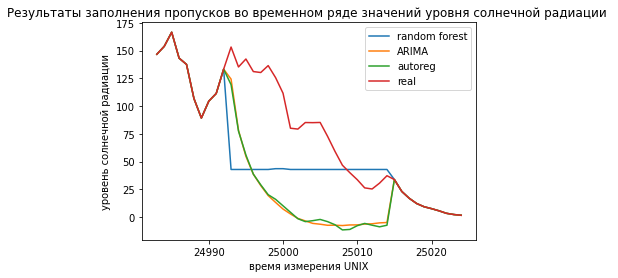

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

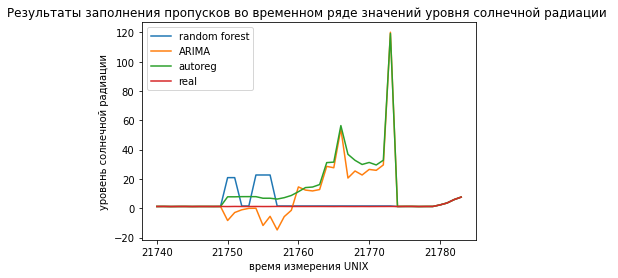

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

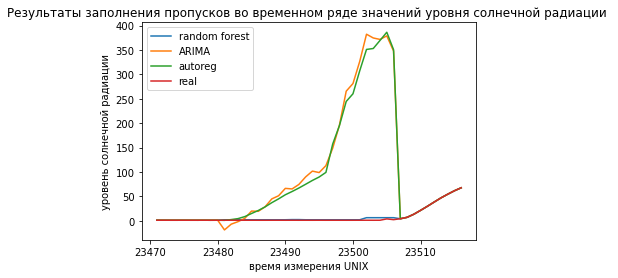

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

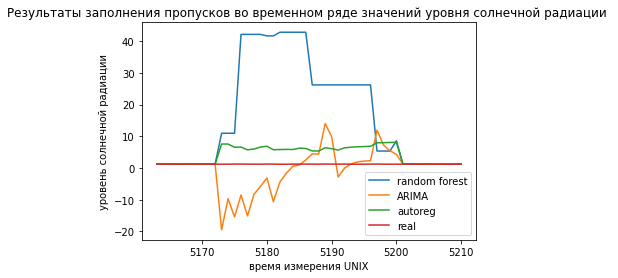

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

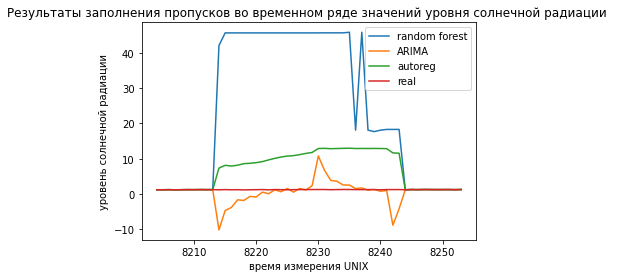

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

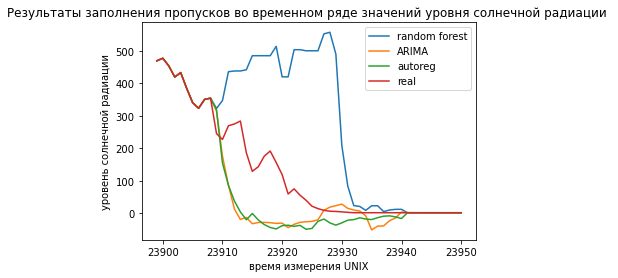

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

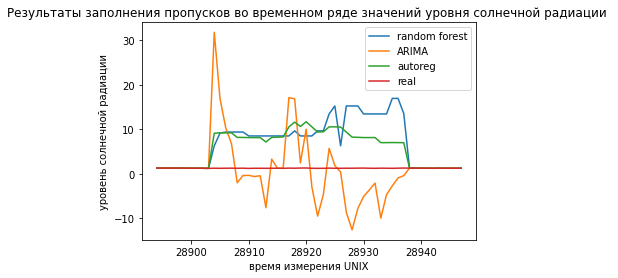

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

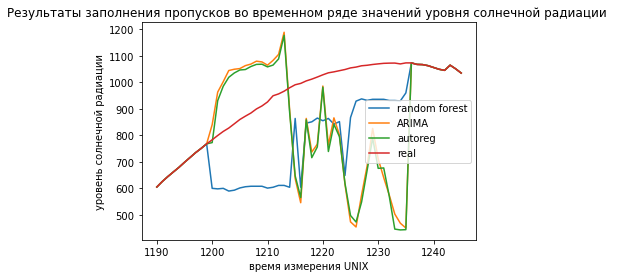

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

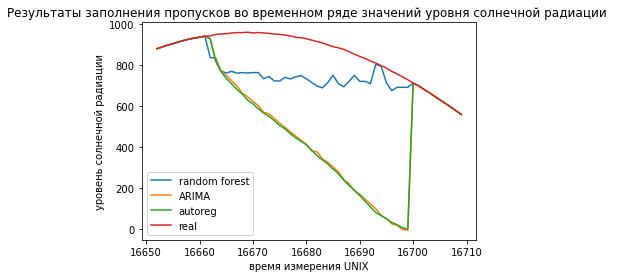

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

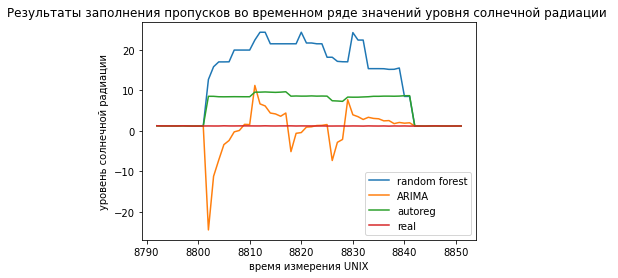

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

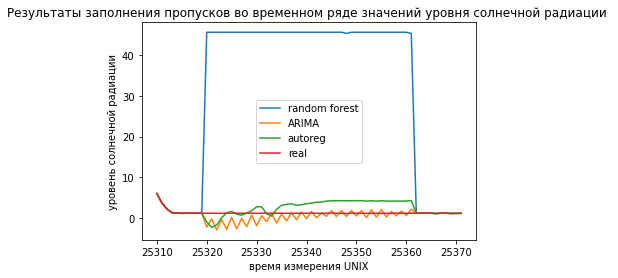

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

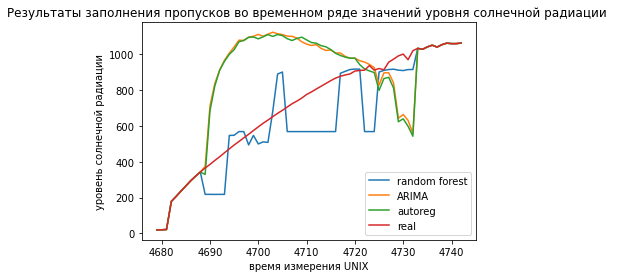

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

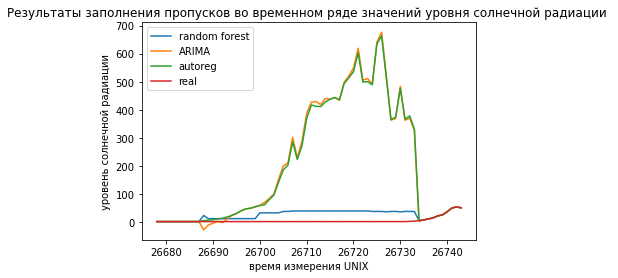

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

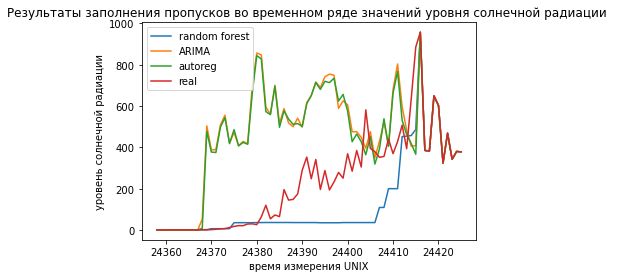

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

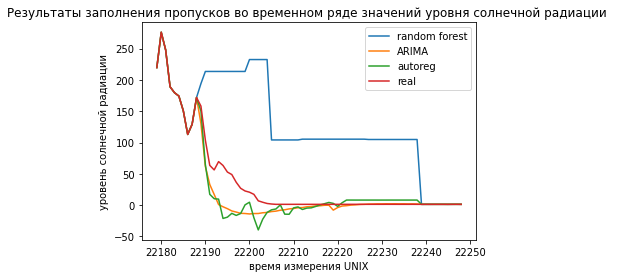

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is

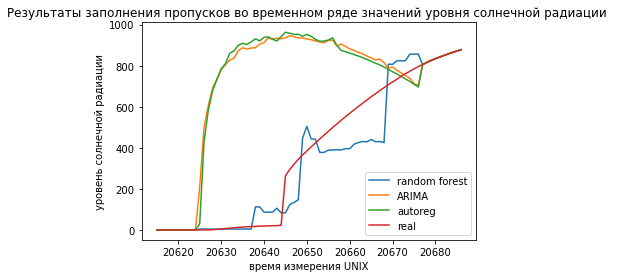

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

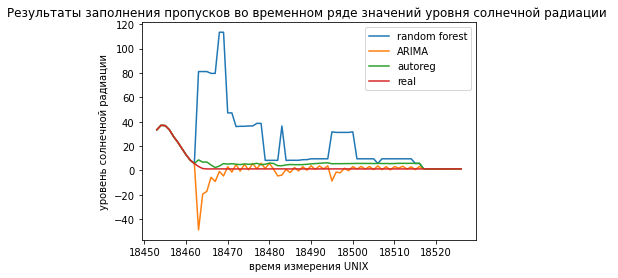

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

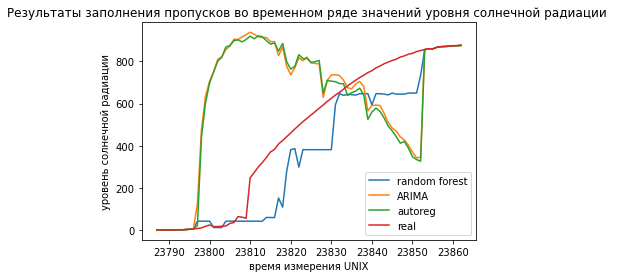

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

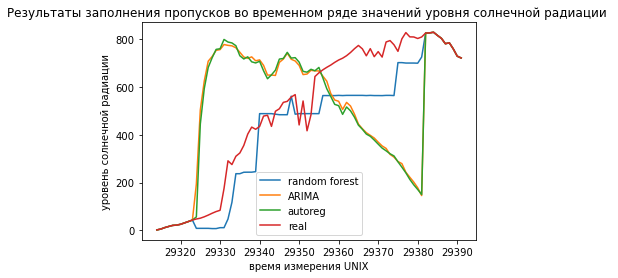

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

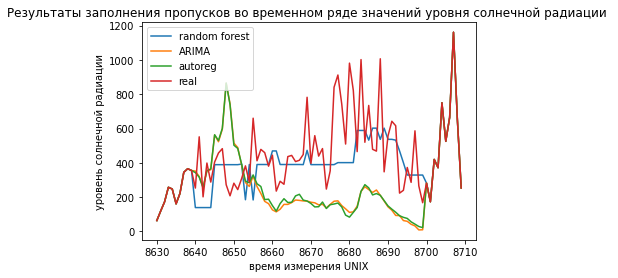

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

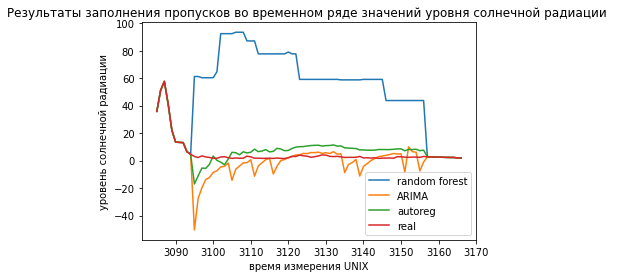

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

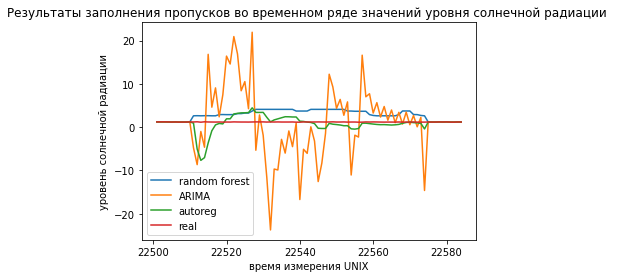

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg


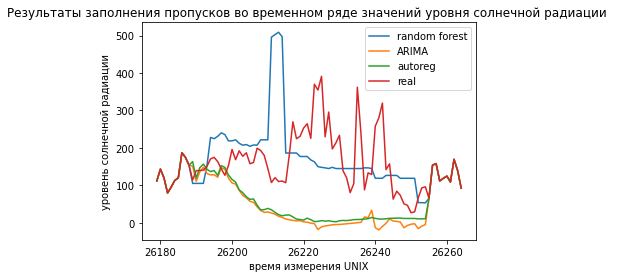

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

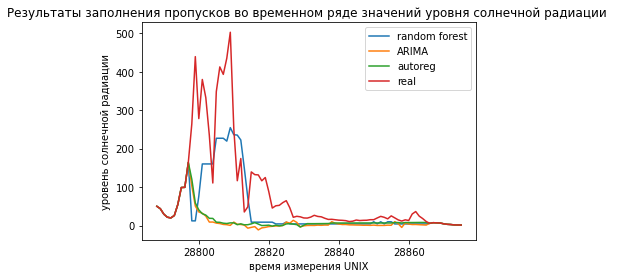

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

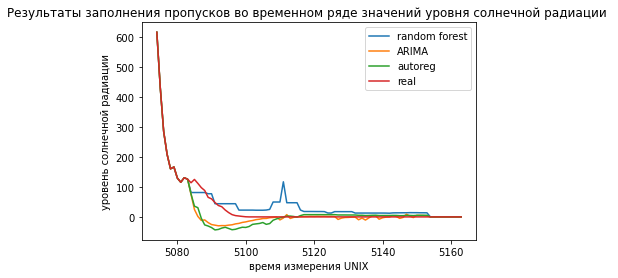

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

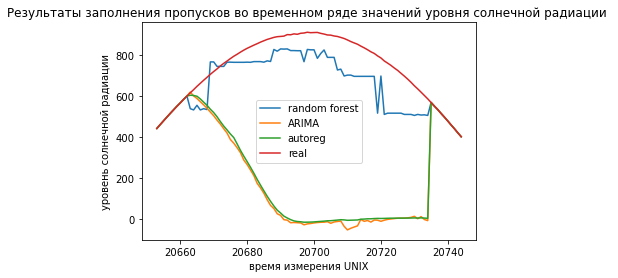

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

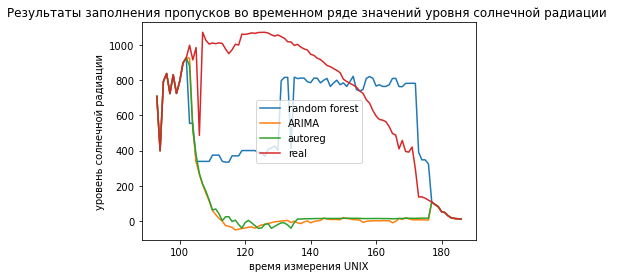

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

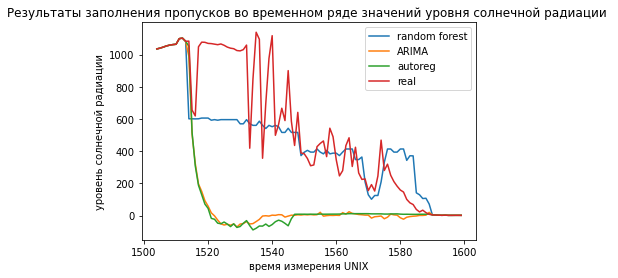

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is

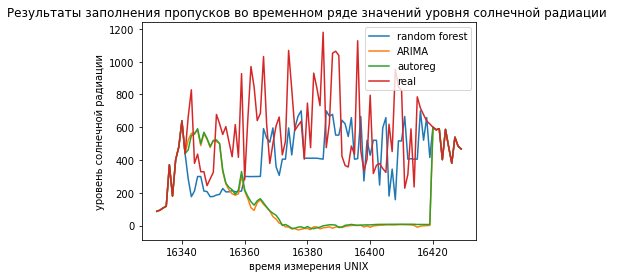

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

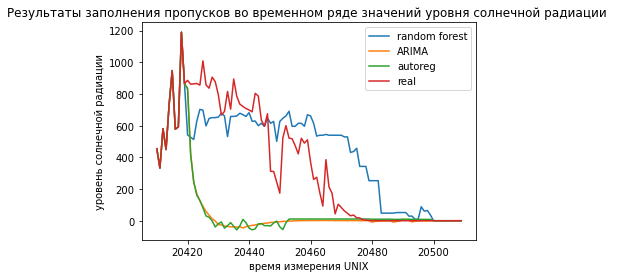

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg


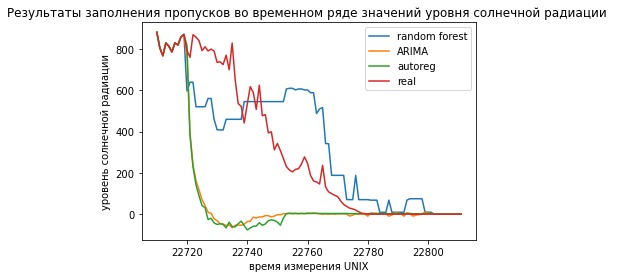

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg


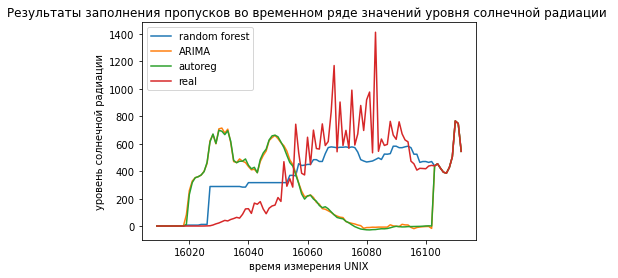

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

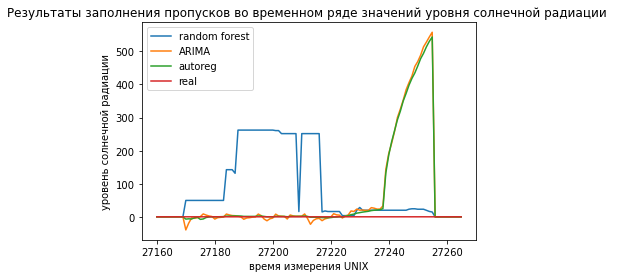

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is

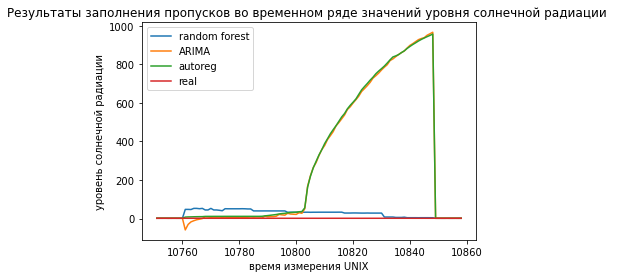

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg


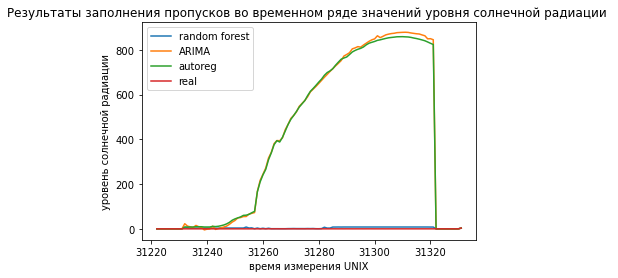

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

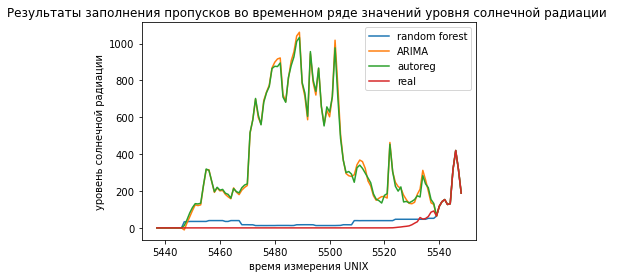

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

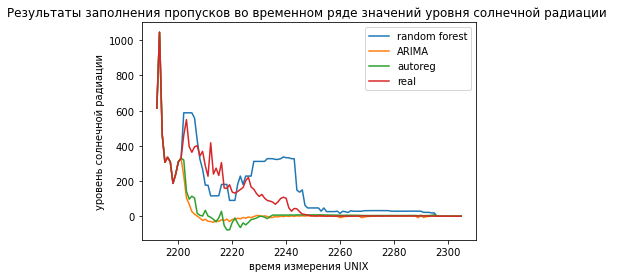

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

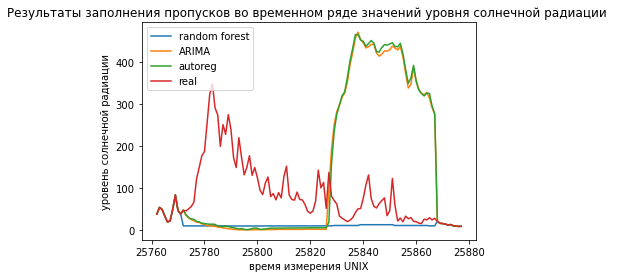

<ipython-input-9-3d30ffa47a48>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\User

<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-36-501168166179>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-36-501168166179>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is

<ipython-input-36-501168166179>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg


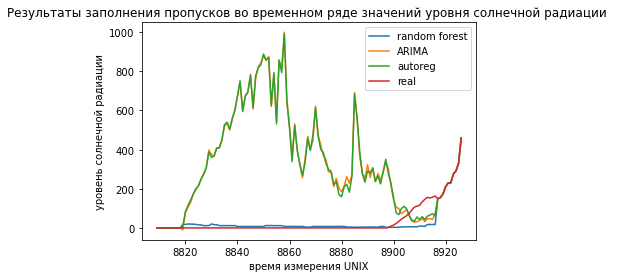

In [39]:
mse_list_forest=([])
mse_list_ARIMA=([])
mse_list_autoreg=([])
ind_droped=([])

x=np.ndarray([])
n=10

while n<100:
    x=np.append(x,n)
    data_forest,data_arima,data_autoreg=calculate_mse_single(n)
    n+=2

In [ ]:
#Полученные значения MSE

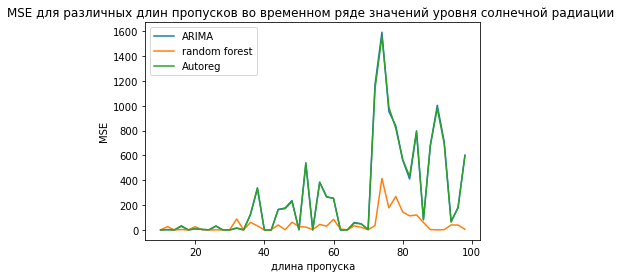

In [40]:
x=np.delete(x, 0)
plt.plot(x,mse_list_ARIMA,label='ARIMA')
plt.plot(x,mse_list_forest,label='random forest')
plt.plot(x,mse_list_autoreg,label='Autoreg')
plt.xlabel('длина пропуска')
plt.ylabel('MSE')
plt.title('MSE для различных длин пропусков во временном ряде значений уровня солнечной радиации ')


plt.legend()
plt.show()

In [66]:
print('--------MSE ARIMA---------')
print('MSE mean = ',np.mean(mse_list_ARIMA))
print('MSE median = ',np.median(mse_list_ARIMA))
print('MSE min = ',np.min(mse_list_ARIMA))
print('MSE max = ',np.max(mse_list_ARIMA))

print('--------MSE RANDOM FOREST---------')
print('MSE mean = ',np.mean(mse_list_forest))
print('MSE median = ',np.median(mse_list_forest))
print('MSE min = ',np.min(mse_list_forest))
print('MSE max = ',np.max(mse_list_forest))

print('--------MSE Autoreg---------')
print('MSE mean = ',np.mean(mse_list_autoreg))
print('MSE median = ',np.median(mse_list_autoreg))
print('MSE min = ',np.min(mse_list_autoreg))
print('MSE max = ',np.max(mse_list_autoreg))


--------MSE ARIMA---------
MSE mean =  273.74464822509077
MSE median =  69.22629398302495
MSE min =  0.0035468770621649897
MSE max =  1591.8138785150347
--------MSE RANDOM FOREST---------
MSE mean =  45.511911997115234
MSE median =  22.60402906175764
MSE min =  0.0007091381682119493
MSE max =  414.9319706802853
--------MSE Autoreg---------
MSE mean =  272.3695606266199
MSE median =  62.86018838186016
MSE min =  0.0008744412120065693
MSE max =  1559.9035395891174


In [ ]:
#Функция для создания множественных пропусков

In [44]:
def lets_drop_some_data_multy(X,num_skip):
    ind_skip=random.randint(0,len(X))
    i=ind_skip
    size=ind_skip+num_skip
    while i <(ind_skip+num_skip):
        if X['Radiation'][i]!=np.nan:
            X['Radiation'][i]=np.nan
            i+=1
            
    return X,ind_skip,size

In [45]:
def lets_make_num_prop(i,k):
    len_prop=i
    num_of_props=k
    data_droped=data.copy(deep=True)
    
    number_props=0
    
    ind_skipped=([])
    
    while number_props< num_of_props:
        data_droped,st,ed=lets_drop_some_data_multy(data_droped,len_prop)
        ind_skipped.append((st,ed))
        number_props+=1
   
    return ind_skipped,data_droped

In [ ]:
#Функция для заполнения множественных пропусков

In [51]:
def calculate_mse_multy(n,k):
    len_prop=n
    num_of_props=k
    ind_skipped,data_droped=lets_make_num_prop(len_prop,num_of_props)
    
    data_int_ARIMA=data_droped.copy(deep=True)
    data_int_forest=data_droped.copy(deep=True)
    data_int_autoreg=data_droped.copy(deep=True)
    
    data_study=data_droped.copy(deep=True)
    
    data_study=data_study.dropna()
    
    total_exog_params=data[['Temperature', 'Pressure','Humidity']]
    
    exog_params = data_study[['Temperature', 'Pressure','Humidity']]
    
    model = ARIMA(endog=data_study['Radiation'],exog=exog_params,order=(5, 1, 3))
    model_fit = model.fit()
    
    model_autoreg = AutoReg(data_study['Radiation'], lags=33,exog=exog_params, seasonal=False)
    model_autoreg_fit = model_autoreg.fit()
    
    X = data_study[['UNIX','Temperature', 'Pressure','Humidity']]
    y = data_study[['Radiation']]
    
    forest = RandomForestRegressor(max_depth=10, random_state=0)
    forest = forest.fit(X, y)
    
    for j in range(len(data_droped)):
        if np.isnan(data_droped['Radiation'][j]):
            
            UNIX=data_droped.UNIX[j]
            Temperature=data_droped.Temperature[j]
            Pressure=data_droped.Pressure[j]
            Humidity=data_droped.Humidity[j]
            
            int_arima=model_fit.predict(start=j, end=j,exog=total_exog_params[(j-1):j])
            data_int_ARIMA.Radiation[j] =int_arima 
            #print('int_arima',int_arima)
            int_forest=forest.predict([[UNIX,Temperature,Pressure,Humidity]])
            data_int_forest.Radiation[j]=int_forest
            #print('int_forest',int_forest)
            int_autoreg=model_autoreg_fit.predict(start=j, end=j,exog=exog_params,exog_oos=total_exog_params[(j-1):j])
            data_int_autoreg.Radiation[j] =int_autoreg
            #print('int_autoreg',int_autoreg)     
    
    mse_ARIMA=mean_squared_error(data['Radiation'],data_int_ARIMA['Radiation'])
    print('mse_ARIMA',mse_ARIMA)
    mse_forest=mean_squared_error(data['Radiation'],data_int_forest['Radiation'])
    print('mse_forest',mse_forest)
    mse_autoreg=mean_squared_error(data['Radiation'],data_int_autoreg['Radiation'])
    print('mse_autoreg',mse_autoreg)
    
    x1=float(mse_forest)
    x2=float(mse_ARIMA)
    x3=float(mse_autoreg)
    
    return x1,x2,x3

In [ ]:
#Вычисление MSE для различных сочетаний количества и длины пропусков

In [52]:
x1,x2,x3=calculate_mse_multy(10,10)

<ipython-input-44-a44e8c1941bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Use

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

mse_ARIMA 140.2258552873534
mse_forest 9.092490643921618
mse_autoreg 130.90329851419017


In [53]:
mse_forest_10_10,mse_ARIMA_10_10,mse_autoreg_10_10=x1,x2,x3

In [56]:
print(mse_forest_10_10,mse_ARIMA_10_10,mse_autoreg_10_10)

9.092490643921618 140.2258552873534 130.90329851419017


In [54]:
mse_forest_10_30,mse_ARIMA_10_30,mse_autoreg_10_30=calculate_mse_multy(10,30)

<ipython-input-44-a44e8c1941bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Use

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

mse_ARIMA 2715.6065542389106
mse_forest 259.98578893746253
mse_autoreg 2662.792216060557


<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

In [57]:
print(mse_forest_10_30,mse_ARIMA_10_30,mse_autoreg_10_30)

259.98578893746253 2715.6065542389106 2662.792216060557


In [58]:
mse_forest_30_10,mse_ARIMA_30_10,mse_autoreg_30_10=calculate_mse_multy(30,10)

<ipython-input-44-a44e8c1941bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Use

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

mse_ARIMA 1891.1229132402325
mse_forest 129.47058546794148
mse_autoreg 1861.288886967355


In [65]:
print(mse_forest_30_10,mse_ARIMA_10_30,mse_autoreg_10_30)

129.47058546794148 2715.6065542389106 2662.792216060557


In [59]:
mse_forest_50_10,mse_ARIMA_50_10,mse_autoreg_50_10=calculate_mse_multy(50,10)

<ipython-input-44-a44e8c1941bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Use

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

mse_ARIMA 2729.7297420387463
mse_forest 370.8072943201613
mse_autoreg 2613.529519989702


<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

In [64]:
print(mse_forest_50_10,mse_ARIMA_50_10,mse_autoreg_50_10)

370.8072943201613 2729.7297420387463 2613.529519989702


In [61]:
mse_forest_50_30,mse_ARIMA_50_30,mse_autoreg_50_30=calculate_mse_multy(50,30)

<ipython-input-44-a44e8c1941bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

mse_ARIMA 10112.475952700055
mse_forest 957.8865707563876
mse_autoreg 9928.15100228299


In [63]:
print(mse_forest_50_30,mse_ARIMA_50_30,mse_autoreg_50_30)

957.8865707563876 10112.475952700055 9928.15100228299


In [67]:
mse_forest_30_30,mse_ARIMA_30_30,mse_autoreg_30_30=calculate_mse_multy(30,30)

<ipython-input-44-a44e8c1941bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Radiation'][i]=np.nan
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Vi\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
<ipython-input-51-a5a5a72960ce>:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest = forest.fit(X, y)
<ipython-in

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is

<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_autoreg.Radiation[j] =int_autoreg
<ipython-input-51-a5a5a72960ce>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_ARIMA.Radiation[j] =int_arima
<ipython-input-51-a5a5a72960ce>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_int_forest.Radiation[j]=int_forest
<ipython-input-51-a5a5a72960ce>:45: SettingWithCopyWarning: 
A value is

mse_ARIMA 6975.702778254095
mse_forest 938.2254295413031
mse_autoreg 6763.700377002654


In [70]:
print(mse_forest_30_30,mse_ARIMA_30_30,mse_autoreg_30_30)

938.2254295413031 6975.702778254095 6763.700377002654


In [148]:
mse_matrix_forest=np.matrix([[round(mse_forest_10_10,1),round(mse_forest_10_30,1)],
                           [round(mse_forest_30_10,1),round(mse_forest_30_30,1)],
                           [round(mse_forest_50_10,1),round(mse_forest_50_30,1)]])

In [150]:
print(mse_matrix_forest)

[[  9.1 260. ]
 [129.5 938.2]
 [370.8 957.9]]


In [ ]:
#Визуализация результатов

<AxesSubplot:>

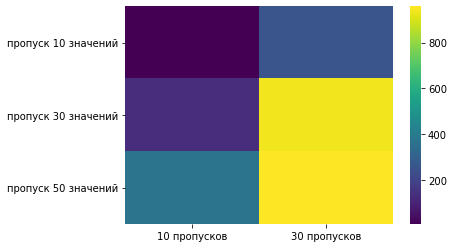

In [149]:
sns.heatmap(mse_matrix_forest, cmap='viridis',xticklabels=['10 пропусков','30 пропусков'], 
            yticklabels=['пропуск 10 значений','пропуск 30 значений','пропуск 50 значений'])

<AxesSubplot:>

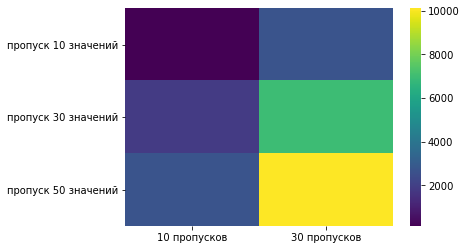

In [95]:
mse_matrix_ARIMA=np.matrix([[round(mse_ARIMA_10_10,1),round(mse_ARIMA_10_30,1)],
                           [round(mse_ARIMA_30_10,1),round(mse_ARIMA_30_30,1)],
                           [round(mse_ARIMA_50_10,1),round(mse_ARIMA_50_30,1)]])

sns.heatmap(mse_matrix_ARIMA, cmap='viridis',xticklabels=['10 пропусков','30 пропусков'], 
            yticklabels=['пропуск 10 значений','пропуск 30 значений','пропуск 50 значений'])

In [151]:
print(mse_matrix_ARIMA)

[[  140.2  2715.6]
 [ 1891.1  6975.7]
 [ 2729.7 10112.5]]


<AxesSubplot:>

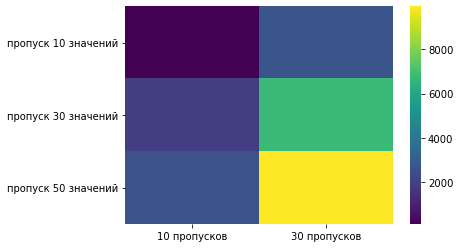

In [96]:
mse_matrix_autoreg=np.matrix([[round(mse_autoreg_10_10,1),round(mse_autoreg_10_30,1)],
                           [round(mse_autoreg_30_10,1),round(mse_autoreg_30_30,1)],
                           [round(mse_autoreg_50_10,1),round(mse_autoreg_50_30,1)]])

sns.heatmap(mse_matrix_autoreg, cmap='viridis',xticklabels=['10 пропусков','30 пропусков'], 
            yticklabels=['пропуск 10 значений','пропуск 30 значений','пропуск 50 значений'])

In [152]:
print(mse_matrix_autoreg)

[[ 130.9 2662.8]
 [1861.3 6763.7]
 [2613.5 9928.2]]


In [113]:
print([round(mse_forest_10_10,1),round(mse_forest_30_10),round(mse_forest_50_10)])
print([round(mse_ARIMA_10_10,1),round(mse_ARIMA_30_10),round(mse_ARIMA_50_10)])
print([round(mse_autoreg_10_10,1),round(mse_autoreg_30_10),round(mse_autoreg_50_10)])

[9.1, 129, 371]
[140.2, 1891, 2730]
[130.9, 1861, 2614]


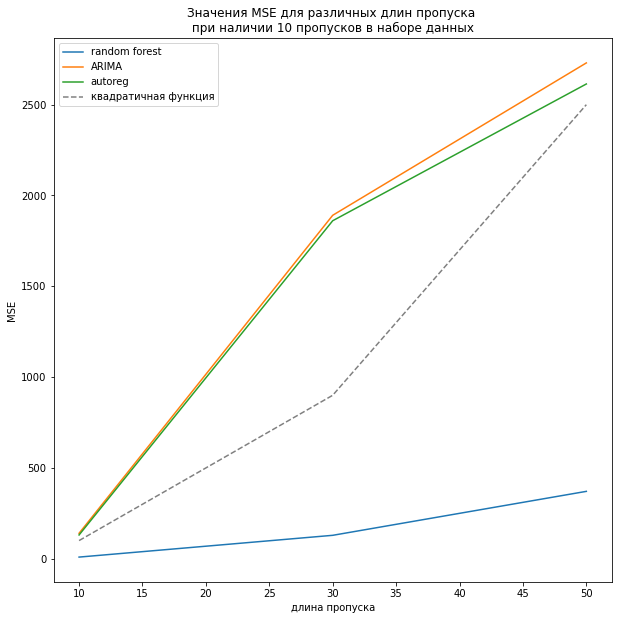

In [138]:
plt.figure(figsize=(10,10))
x=[10,30,50]
y1=[9.1, 129, 371]
y2=[140.2, 1891, 2730]
y3=[130.9, 1861, 2614]
y4=[100,900,2500]

plt.plot(x,y1,label='random forest')
plt.plot(x,y2,label='ARIMA')
plt.plot(x,y3,label='autoreg')
plt.plot(x,y4,linestyle = '--',label='квадратичная функция',color='grey')
plt.xlabel('длина пропуска')
plt.ylabel('MSE')
plt.title('Значения MSE для различных длин пропуска \n при наличии 10 пропусков в наборе данных ')
plt.legend()
plt.show()

In [117]:
print([round(mse_forest_10_30,1),round(mse_forest_30_30),round(mse_forest_50_30)])
print([round(mse_ARIMA_10_30,1),round(mse_ARIMA_30_30),round(mse_ARIMA_50_30)])
print([round(mse_autoreg_10_30,1),round(mse_autoreg_30_30),round(mse_autoreg_50_30)])

[260.0, 938, 958]
[2715.6, 6976, 10112]
[2662.8, 6764, 9928]


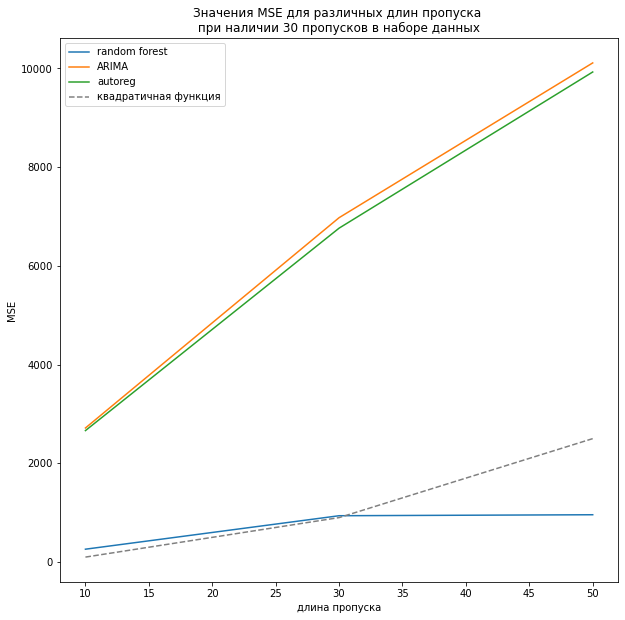

In [139]:
plt.figure(figsize=(10,10))
x=[10,30,50]
y1=[260.0, 938, 958]
y2=[2715.6, 6976, 10112]
y3=[2662.8, 6764, 9928]
y4=[100,900,2500]


plt.plot(x,y1,label='random forest')
plt.plot(x,y2,label='ARIMA')
plt.plot(x,y3,label='autoreg')
plt.plot(x,y4,linestyle = '--',label='квадратичная функция',color='grey')
plt.xlabel('длина пропуска')
plt.ylabel('MSE')
plt.title('Значения MSE для различных длин пропуска \n при наличии 30 пропусков в наборе данных ')
plt.legend()
plt.show()

In [127]:
print([round(mse_forest_10_10,1),np.mean([round(mse_forest_10_30),round(mse_forest_30_10)]),round(mse_forest_30_30),round(mse_forest_50_30)])
print([round(mse_ARIMA_10_10,1),np.mean([round(mse_ARIMA_10_30),round(mse_ARIMA_30_10)]),round(mse_ARIMA_30_30),round(mse_ARIMA_50_30)])
print([round(mse_autoreg_10_10,1),np.mean([round(mse_autoreg_10_30),round(mse_autoreg_30_10)]),round(mse_autoreg_30_30),round(mse_autoreg_50_30)])

[9.1, 194.5, 938, 958]
[140.2, 2303.5, 6976, 10112]
[130.9, 2262.0, 6764, 9928]


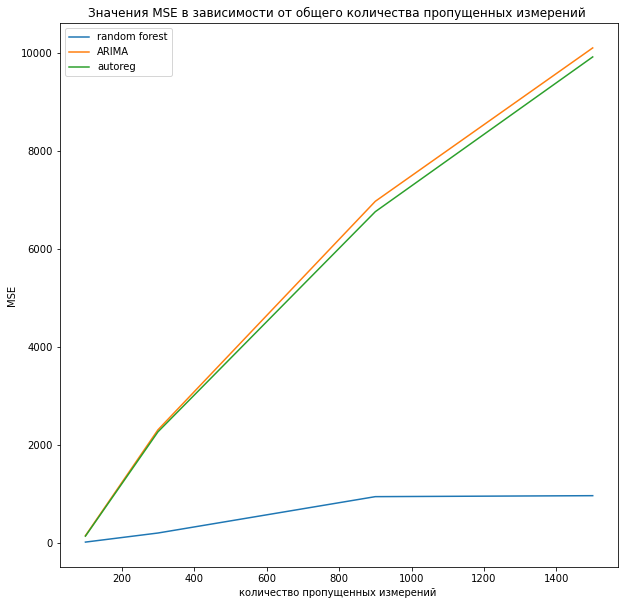

In [140]:
plt.figure(figsize=(10,10))
x=[100,300,900,1500]
y1=[9.1, 194.5, 938, 958]
y2=[140.2, 2303.5, 6976, 10112]
y3=[130.9, 2262.0, 6764, 9928]


plt.plot(x,y1,label='random forest')
plt.plot(x,y2,label='ARIMA')
plt.plot(x,y3,label='autoreg')

plt.xlabel('количество пропущенных измерений ')
plt.ylabel('MSE')
plt.title('Значения MSE в зависимости от общего количества пропущенных измерений ')
plt.legend()
plt.show()